In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Input, LSTM, GRU, Dense, Dropout
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

FILES = {
    "Apple":  "Apple_clean.csv",
    "Samsung":"Samsung_clean.csv",
    "Xiaomi": "Xiaomi_clean.csv"
}

FORECAST_START = pd.to_datetime("2025-10-29")
FORECAST_DAYS = 30
TIME_STEP = 40    

In [10]:
def load_series(path):
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values("Date").reset_index(drop=True)
    return df[['Date','Close']]

In [11]:
def build_lstm(ts):
    model = Sequential([
        Input(shape=(ts, 1)),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dropout(0.15),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


def build_gru(ts):
    model = Sequential([
        Input(shape=(ts, 1)),
        GRU(64),
        Dropout(0.15),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [12]:
def make_windows(arr, ts):
    X, y = [], []
    for i in range(len(arr) - ts):
        X.append(arr[i:i+ts, 0])
        y.append(arr[i+ts, 0])
    return np.array(X).reshape((-1, ts, 1)), np.array(y)

In [13]:
def forecast_next(model, last_win, n, scaler):
    seq = list(last_win.flatten())
    preds = []

    for _ in range(n):
        x = np.array(seq[-len(last_win):]).reshape(1, len(last_win), 1)
        y = model.predict(x, verbose=0)[0][0]
        seq.append(y)
        preds.append(y)

    return scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()


In [14]:
results = {}

for name, path in FILES.items():

    print(f"\n=== Processing {name} ===")

    df = load_series(path)
    close = df["Close"].values.reshape(-1, 1)

    n = len(close)
    ts = min(TIME_STEP, n // 3) if n < TIME_STEP + 10 else TIME_STEP

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(close)

    # Make windows
    X_all, y_all = make_windows(scaled, ts)
    total = len(X_all)

    train_end = int(0.7 * total)
    val_end   = int(0.8 * total)

    X_train, y_train = X_all[:train_end], y_all[:train_end]
    X_val,   y_val   = X_all[train_end:val_end], y_all[train_end:val_end]
    X_test,  y_test  = X_all[val_end:], y_all[val_end:]

    print(f"Windows → Train {len(X_train)}, Val {len(X_val)}, Test {len(X_test)}")

    # Train LSTM
    lstm = build_lstm(ts)
    lstm.fit(X_train, y_train, epochs=80, batch_size=16,
             validation_data=(X_val, y_val),
             callbacks=[EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)],
             verbose=0)

    # Train GRU
    gru = build_gru(ts)
    gru.fit(X_train, y_train, epochs=80, batch_size=16,
            validation_data=(X_val, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)],
            verbose=0)

    # Forecast
    last_window = scaled[-ts:]
    lstm_fc = forecast_next(lstm, last_window, FORECAST_DAYS, scaler)
    gru_fc  = forecast_next(gru,  last_window, FORECAST_DAYS, scaler)

    dates = pd.date_range(start=FORECAST_START, periods=FORECAST_DAYS)

    results[name] = {
        "dates": dates,
        "lstm": lstm_fc,
        "gru": gru_fc
    }




=== Processing Apple ===
Windows → Train 2759, Val 394, Test 789

=== Processing Samsung ===
Windows → Train 2696, Val 385, Test 771

=== Processing Xiaomi ===
Windows → Train 1232, Val 176, Test 352


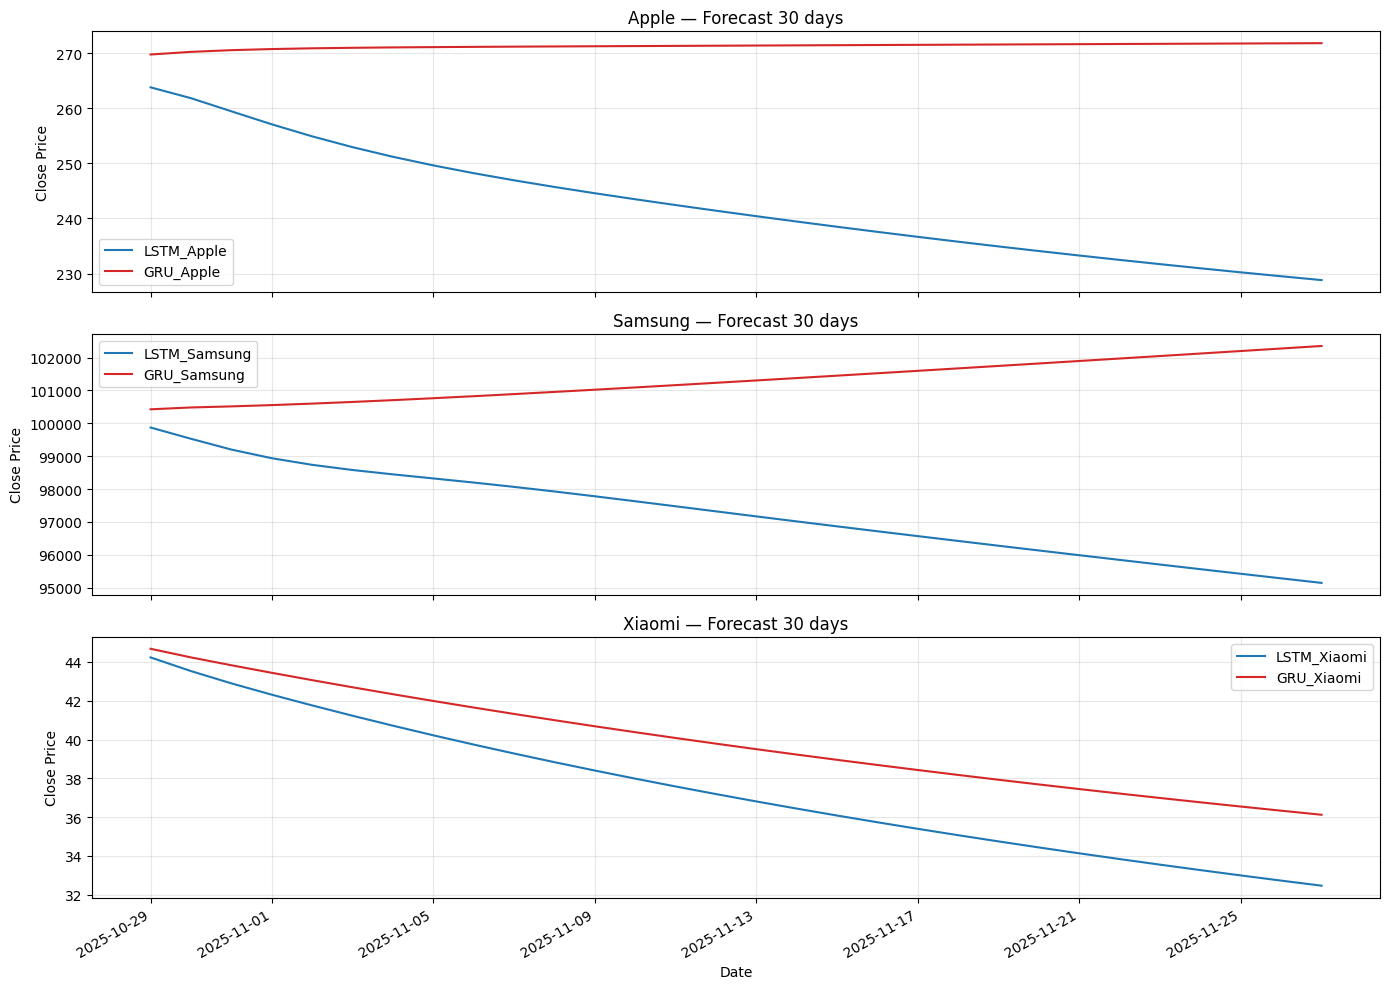

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

stock_list = ["Apple", "Samsung", "Xiaomi"]
colors = {
    "LSTM": "tab:blue",
    "GRU":  "tab:red"
}

for ax, stock in zip(axes, stock_list):
    d = results[stock]["dates"]
    ax.plot(d, results[stock]["lstm"], label=f"LSTM_{stock}", color=colors["LSTM"])
    ax.plot(d, results[stock]["gru"],  label=f"GRU_{stock}",  color=colors["GRU"])

    ax.set_title(f"{stock} — Forecast 30 days")
    ax.set_ylabel("Close Price")
    ax.grid(alpha=0.3)
    ax.legend()

axes[-1].set_xlabel("Date")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

In [16]:
# -------------------------
# PRINT 30-DAY FORECAST TABLES
# -------------------------

for stock in stock_list:
    print("\n==============================================")
    print(f"       30-DAY FORECAST TABLE — {stock}")
    print("==============================================")

    df_table = pd.DataFrame({
        "Date": results[stock]["dates"],
        "LSTM_Forecast": results[stock]["lstm"],
        "GRU_Forecast":  results[stock]["gru"]
    })

    # Làm đẹp bảng
    df_table["Date"] = df_table["Date"].dt.strftime("%Y-%m-%d")
    df_table = df_table.round(4)

    print(df_table.to_string(index=False))



       30-DAY FORECAST TABLE — Apple
      Date  LSTM_Forecast  GRU_Forecast
2025-10-29     263.776703    269.730194
2025-10-30     261.808411    270.210205
2025-10-31     259.430298    270.517609
2025-11-01     257.070709    270.718994
2025-11-02     254.889008    270.854004
2025-11-03     252.928101    270.947998
2025-11-04     251.180801    271.017090
2025-11-05     249.618805    271.071106
2025-11-06     248.207596    271.116089
2025-11-07     246.913406    271.155609
2025-11-08     245.707596    271.191986
2025-11-09     244.567703    271.226410
2025-11-10     243.477097    271.259888
2025-11-11     242.424393    271.292603
2025-11-12     241.402298    271.325012
2025-11-13     240.406601    271.356995
2025-11-14     239.434998    271.388794
2025-11-15     238.486404    271.420593
2025-11-16     237.560501    271.451996
2025-11-17     236.657303    271.483307
2025-11-18     235.776703    271.514404
2025-11-19     234.918594    271.545410
2025-11-20     234.082794    271.575989
20